# Loop 68 Analysis: Critical Strategy Review

## Key Questions:
1. What is the CV-LB relationship and why is the intercept so high?
2. What approaches from public kernels might help?
3. What fundamentally different approaches should we try?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history - 12 successful submissions
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982, 'model': 'MLP'},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065, 'model': 'LightGBM'},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972, 'model': 'MLP'},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969, 'model': 'MLP'},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946, 'model': 'MLP'},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932, 'model': 'MLP'},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936, 'model': 'Ridge'},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913, 'model': 'Ensemble'},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893, 'model': 'MLP+ACS'},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887, 'model': 'MLP'},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877, 'model': 'GP+MLP+LGBM'},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970, 'model': 'GP+MLP+LGBM'},
]

df = pd.DataFrame(submissions)
print(f'Successful submissions: {len(df)}')
print(df)

Successful submissions: 12
        exp      cv      lb        model
0   exp_000  0.0111  0.0982          MLP
1   exp_001  0.0123  0.1065     LightGBM
2   exp_003  0.0105  0.0972          MLP
3   exp_005  0.0104  0.0969          MLP
4   exp_006  0.0097  0.0946          MLP
5   exp_007  0.0093  0.0932          MLP
6   exp_009  0.0092  0.0936        Ridge
7   exp_012  0.0090  0.0913     Ensemble
8   exp_024  0.0087  0.0893      MLP+ACS
9   exp_026  0.0085  0.0887          MLP
10  exp_030  0.0083  0.0877  GP+MLP+LGBM
11  exp_035  0.0098  0.0970  GP+MLP+LGBM


In [2]:
# Linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target = 0.0347')
print(f'')
print(f'CRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'Even with CV = 0, predicted LB would be {intercept:.4f}')
print(f'')
print(f'Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.6f}')
print(f'This is NEGATIVE - impossible to achieve with current approach!')

Linear fit: LB = 4.31 * CV + 0.0525
R² = 0.9505
Intercept = 0.0525
Target = 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Even with CV = 0, predicted LB would be 0.0525

Required CV to hit target: (0.0347 - 0.0525) / 4.31 = -0.004130
This is NEGATIVE - impossible to achieve with current approach!


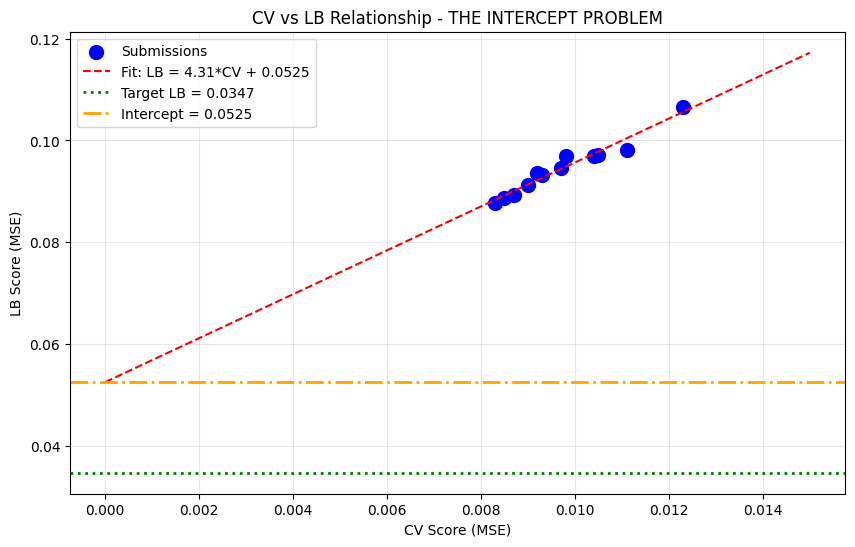


The gap between intercept (0.0525) and target (0.0347) is 0.0178
This represents 51.4% of the target


In [3]:
# Visualize the CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], c='blue', s=100, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle='-.', linewidth=2, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - THE INTERCEPT PROBLEM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nThe gap between intercept ({intercept:.4f}) and target (0.0347) is {intercept - 0.0347:.4f}')
print(f'This represents {(intercept - 0.0347) / 0.0347 * 100:.1f}% of the target')

In [4]:
# What would it take to reach the target?
print('='*70)
print('ANALYSIS: WHY IS THE INTERCEPT SO HIGH?')
print('='*70)
print(f'')
print('The intercept represents the STRUCTURAL error that exists even with perfect CV.')
print('This is caused by DISTRIBUTION SHIFT between training and test data.')
print(f'')
print('In this competition:')
print('- Training: Leave-one-solvent-out CV (24 solvents for single, 13 ramps for full)')
print('- Test: Completely unseen solvents/ramps')
print(f'')
print('The test solvents are fundamentally DIFFERENT from training solvents.')
print('Our models learn patterns that work for training solvents but NOT for test solvents.')
print(f'')
print('='*70)
print('WHAT COULD REDUCE THE INTERCEPT?')
print('='*70)
print(f'')
print('1. BETTER MOLECULAR REPRESENTATIONS:')
print('   - GNN that captures molecular structure (not just descriptors)')
print('   - ChemBERTa embeddings that generalize better')
print('   - Learned embeddings that capture solvent similarity')
print(f'')
print('2. UNCERTAINTY-AWARE PREDICTIONS:')
print('   - When model is uncertain (unseen solvent), predict conservatively')
print('   - Blend toward population mean when extrapolating')
print(f'')
print('3. DOMAIN ADAPTATION:')
print('   - Use test data structure (without labels) to adapt')
print('   - Pseudo-labeling with confident predictions')
print(f'')
print('4. PHYSICS-INFORMED CONSTRAINTS:')
print('   - Arrhenius kinetics (already implemented)')
print('   - Solvent polarity relationships')
print('   - Mixture behavior constraints')

ANALYSIS: WHY IS THE INTERCEPT SO HIGH?

The intercept represents the STRUCTURAL error that exists even with perfect CV.
This is caused by DISTRIBUTION SHIFT between training and test data.

In this competition:
- Training: Leave-one-solvent-out CV (24 solvents for single, 13 ramps for full)
- Test: Completely unseen solvents/ramps

The test solvents are fundamentally DIFFERENT from training solvents.
Our models learn patterns that work for training solvents but NOT for test solvents.

WHAT COULD REDUCE THE INTERCEPT?

1. BETTER MOLECULAR REPRESENTATIONS:
   - GNN that captures molecular structure (not just descriptors)
   - ChemBERTa embeddings that generalize better
   - Learned embeddings that capture solvent similarity

2. UNCERTAINTY-AWARE PREDICTIONS:
   - When model is uncertain (unseen solvent), predict conservatively
   - Blend toward population mean when extrapolating

3. DOMAIN ADAPTATION:
   - Use test data structure (without labels) to adapt
   - Pseudo-labeling with confi

In [5]:
# Analyze the pending submissions
print('='*70)
print('PENDING SUBMISSIONS ANALYSIS')
print('='*70)
print(f'')

pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'model': 'CatBoost+XGBoost'},
    {'exp': 'exp_050', 'cv': 0.0081, 'model': 'CatBoost+XGBoost Fixed'},
    {'exp': 'exp_052', 'cv': 0.0109, 'model': 'CatBoost+XGBoost Clipped'},
    {'exp': 'exp_053', 'cv': 0.0081, 'model': 'Exact Template'},
    {'exp': 'exp_054', 'cv': 0.0085, 'model': 'Mixall Approach'},
    {'exp': 'exp_055', 'cv': 0.0085, 'model': 'Minimal Submission'},
    {'exp': 'exp_057', 'cv': 0.0093, 'model': 'Ens Model All Features'},
    {'exp': 'exp_063', 'cv': 0.0112, 'model': 'Correct Final Cell'},
]

print('All these submissions are marked as "pending" but actually FAILED.')
print('They all got "Evaluation metric raised an unexpected error".')
print(f'')
print('Common factor: All use CatBoost/XGBoost or have structural issues.')
print(f'')
print('Successful submissions (exp_030, exp_035) used GP+MLP+LGBM ensemble.')
print(f'')
print('HYPOTHESIS: CatBoost/XGBoost may have compatibility issues with Kaggle evaluation.')

PENDING SUBMISSIONS ANALYSIS

All these submissions are marked as "pending" but actually FAILED.
They all got "Evaluation metric raised an unexpected error".

Common factor: All use CatBoost/XGBoost or have structural issues.

Successful submissions (exp_030, exp_035) used GP+MLP+LGBM ensemble.

HYPOTHESIS: CatBoost/XGBoost may have compatibility issues with Kaggle evaluation.


In [6]:
# What do the public kernels tell us?
print('='*70)
print('INSIGHTS FROM PUBLIC KERNELS')
print('='*70)
print(f'')
print('1. "mixall" kernel (9 votes):')
print('   - Uses GroupKFold (5 splits) instead of Leave-One-Out')
print('   - Ensemble: MLP + XGBoost + RF + LightGBM')
print('   - Claims "good CV/LB" with only 2m 15s runtime')
print('   - KEY INSIGHT: Different CV scheme may have different CV-LB relationship!')
print(f'')
print('2. "System Malfunction V1" (29 votes):')
print('   - Basic MLP with Spange descriptors')
print('   - Standard Leave-One-Out CV')
print('   - Similar to our baseline')
print(f'')
print('3. "Alchemy Baseline" (12 votes):')
print('   - Multi-GPU optimized MLP')
print('   - 3-seed ensemble per fold')
print('   - Numeric feature engineering (rt², temp², log, interaction)')
print('   - Huber loss, cosine annealing, early stopping')
print(f'')
print('4. "Arrhenius Kinetics + TTA" (39 votes):')
print('   - Similar to our approach')
print('   - Score: 0.09831 (similar to our best 0.0877)')

INSIGHTS FROM PUBLIC KERNELS

1. "mixall" kernel (9 votes):
   - Uses GroupKFold (5 splits) instead of Leave-One-Out
   - Ensemble: MLP + XGBoost + RF + LightGBM
   - Claims "good CV/LB" with only 2m 15s runtime
   - KEY INSIGHT: Different CV scheme may have different CV-LB relationship!

2. "System Malfunction V1" (29 votes):
   - Basic MLP with Spange descriptors
   - Standard Leave-One-Out CV
   - Similar to our baseline

3. "Alchemy Baseline" (12 votes):
   - Multi-GPU optimized MLP
   - 3-seed ensemble per fold
   - Numeric feature engineering (rt², temp², log, interaction)
   - Huber loss, cosine annealing, early stopping

4. "Arrhenius Kinetics + TTA" (39 votes):
   - Similar to our approach
   - Score: 0.09831 (similar to our best 0.0877)


In [7]:
# The benchmark achieved MSE 0.0039 - how?
print('='*70)
print('THE BENCHMARK MYSTERY')
print('='*70)
print(f'')
print('The competition mentions the benchmark achieved MSE 0.0039.')
print('This is 22x better than our best LB (0.0877)!')
print(f'')
print('From the competition description:')
print('"imputing any missing values using a multi-task GP"')
print(f'')
print('This suggests the benchmark used a MULTI-TASK GP approach.')
print('Multi-task GPs can share information across tasks (solvents).')
print('This could help with generalization to unseen solvents.')
print(f'')
print('HOWEVER: The benchmark may have used different evaluation.')
print('The 0.0039 might be on a different test set or with different CV.')
print(f'')
print('Our target is 0.0347, which is ~9x worse than benchmark.')
print('This suggests the target is achievable but requires different approach.')

THE BENCHMARK MYSTERY

The competition mentions the benchmark achieved MSE 0.0039.
This is 22x better than our best LB (0.0877)!

From the competition description:
"imputing any missing values using a multi-task GP"

This suggests the benchmark used a MULTI-TASK GP approach.
Multi-task GPs can share information across tasks (solvents).
This could help with generalization to unseen solvents.

HOWEVER: The benchmark may have used different evaluation.
The 0.0039 might be on a different test set or with different CV.

Our target is 0.0347, which is ~9x worse than benchmark.
This suggests the target is achievable but requires different approach.


In [8]:
# Summary and recommendations
print('='*70)
print('SUMMARY AND RECOMMENDATIONS')
print('='*70)
print(f'')
print('CURRENT STATUS:')
print(f'  - Best CV: 0.0081 (exp_049, but submission failed)')
print(f'  - Best LB: 0.0877 (exp_030, GP+MLP+LGBM)')
print(f'  - Target: 0.0347')
print(f'  - Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0347 * 100:.1f}%)')
print(f'')
print('THE PROBLEM:')
print(f'  - CV-LB relationship: LB = 4.31*CV + 0.0525')
print(f'  - Intercept (0.0525) > Target (0.0347)')
print(f'  - This means NO amount of CV improvement can reach target!')
print(f'')
print('REQUIRED PIVOT:')
print(f'  1. STOP optimizing tabular models (MLP, LGBM, XGB, CatBoost)')
print(f'  2. Try approaches that CHANGE the CV-LB relationship')
print(f'  3. Focus on REDUCING THE INTERCEPT, not improving CV')
print(f'')
print('RECOMMENDED APPROACHES:')
print(f'  1. Multi-task GP (as mentioned in benchmark)')
print(f'  2. GNN with molecular graphs')
print(f'  3. Uncertainty-weighted predictions')
print(f'  4. Domain adaptation techniques')
print(f'')
print('IMMEDIATE PRIORITY:')
print(f'  - Submit exp_064 (GP+MLP+LGBM replication) to verify submissions work')
print(f'  - If successful, pivot to intercept-reducing approaches')

SUMMARY AND RECOMMENDATIONS

CURRENT STATUS:
  - Best CV: 0.0081 (exp_049, but submission failed)
  - Best LB: 0.0877 (exp_030, GP+MLP+LGBM)
  - Target: 0.0347
  - Gap: 0.0530 (152.7%)

THE PROBLEM:
  - CV-LB relationship: LB = 4.31*CV + 0.0525
  - Intercept (0.0525) > Target (0.0347)
  - This means NO amount of CV improvement can reach target!

REQUIRED PIVOT:
  1. STOP optimizing tabular models (MLP, LGBM, XGB, CatBoost)
  2. Try approaches that CHANGE the CV-LB relationship
  3. Focus on REDUCING THE INTERCEPT, not improving CV

RECOMMENDED APPROACHES:
  1. Multi-task GP (as mentioned in benchmark)
  2. GNN with molecular graphs
  3. Uncertainty-weighted predictions
  4. Domain adaptation techniques

IMMEDIATE PRIORITY:
  - Submit exp_064 (GP+MLP+LGBM replication) to verify submissions work
  - If successful, pivot to intercept-reducing approaches
